In [1]:
using Roots
include("TypeDefine.jl")
include("PressureGuess.jl")

#function (4.6) and (4.7) from Toro
f(p, status::HydroStatus, ::Shock) = (p - status.p) * sqrt(status.A / (p + status.B))
f(p, status::HydroStatus, ::Rarefaction) = 2. * status.c / (status.gamma - 1.) * ((p / status.p)^((status.gamma - 1.) / 2. /status.gamma) - 1.)
function f(p, status::HydroStatus)
	wave_type = p > status.p ? Shock() : Rarefaction()
	return f(p, status, wave_type)
end

#solver for p_star based on the first guess of the pressure(see PressureGuess.jl)
#uses secant method to find solve the equation
function p_star_calc(left::HydroStatus, right::HydroStatus, guess_scheme::T, TOL::Float64) where {T<:FirstGuessScheme}	
	p0 = max(TOL, p_guess(left, right, guess_scheme))
	
	#we define p = exp(u) so inside the interation it won't get negative value
	u0 = log(p0) #p = exp(u) => u = log(p)
	f_star(u) = f(exp(u), left) + f(exp(u), right) + right.u - left.u #function (4.5) from Toro
	u = find_zero(f_star, u0, Order1(), rtol = TOL) #Secant method
	return exp(u) #p = exp(u) 
end

#equation (4.9) from Toro
u_star_calc(p_star, left::HydroStatus, right::HydroStatus) = 0.5 * (left.u + right.u) +
															 0.5 * (f(p_star, right) - f(p_star, left))


#equations (4.23) and (4.32) from Toro
rho_star_calc(p_star, status::HydroStatus, ::Rarefaction) = status.rho * (p_star / status.p) ^ (1. / status.gamma)

#equation (4.25) and (4.34) from Toro
c_star_calc(p_star, status::HydroStatus, ::Rarefaction) = status.c * (p_star / status.p) ^ ((status.gamma - 1.) / 2. / status.gamma)

#equations (4.50) and (4.57) from Toro
function rho_star_calc(p_star, status::HydroStatus, ::Shock)
	gamma_ratio = (status.gamma - 1.) / (status.gamma + 1.)
	pressure_ratio = p_star / status.p
	return status.rho * (pressure_ratio + gamma_ratio) / (pressure_ratio * gamma_ratio + 1.)
end

#equation (4.55) and (4.62) from Toro 
head_speed_calc(p_star, u_star, status::HydroStatus,
				side::T, ::Rarefaction) where {T<:Side} = status.u + side_factor(side) * status.c

#equation (4.55) and (4.62) from Toro 
function tail_speed_calc(p_star, u_star, status::HydroStatus, side::T, ::Rarefaction) where {T<:Side}
	c_star = c_star_calc(p_star, status, Rarefaction())
	return u_star + side_factor(side) * c_star
end

#equations (4.52) and (4.59) from Toro
function head_speed_calc(p_star, u_star, status::HydroStatus, side::T, ::Shock) where {T<:Side}
	gamma = status.gamma
	gamma_ratio1 = (gamma + 1.) / 2. / gamma
	gamma_ratio2 = (gamma - 1.) / 2. / gamma
	return status.u + side_factor(side) * status.c * sqrt(gamma_ratio1 * p_star / status.p + gamma_ratio2)
end

#for shock the head and the tail are the same
tail_speed_calc(p_star, u_star, status::HydroStatus, side::T, ::Shock) where {T<:Side} = head_speed_calc(p_star, u_star, status, side, Shock())


#for vaccum generation the density in the middle is zero (= vaccum)
rho_star_calc(p_star, status::HydroStatus, ::Vaccum) = 0.

#those are the velocities of the head and the tail of the rarefaciton wave when a vaccum is generated
#see (4.76), (4.77), (4.79) and (4.80) from Toro
head_speed_calc(p_star, u_star, status::HydroStatus,
				side::T, ::Vaccum) where {T<:Side} = status.u + side_factor(side) * status.c
tail_speed_calc(p_star, u_star, status::HydroStatus, side::T, ::Vaccum) where {T<:Side} = status.u - side_factor(side) * 2 * status.c / (status.gamma - 1.)

#this is the density, velocity and pressure profile of a rarefaction wave in some specific x/t	
#see (4.56) and (4.63) from Toro
function rarefaction_profile(x_over_t, status::HydroStatus, side::T) where {T<:Side}
	gamma = status.gamma
	gamma_ratio = (gamma - 1.) / (gamma + 1.)
	gamma_plus = 2. / (gamma + 1.)
	gamma_minus = 2. / (gamma - 1.)
	
	rarefaction_factor = (gamma_plus - side_factor(side) * gamma_ratio / status.c * (status.u - x_over_t)) ^ gamma_minus
	
	rho = status.rho * rarefaction_factor
	u = gamma_plus * (-side_factor(side)*status.c + (1. /gamma_minus) * status.u + x_over_t)
	p = status.p * rarefaction_factor ^ gamma
	
	return HydroStatusSimple(rho, u, p)
end

#sample the riemann problem in the situation where both sides are not vaccum (but vaccum can be generated through the dynamics)
function sample_riemann_regular(x, t::Float64, left::HydroStatus, right::HydroStatus,
								  guess_scheme::T, TOL::Float64) where {T<:FirstGuessScheme}
	@assert left.rho != 0.
	@assert right.rho != 0.
	
	profile = similar(x, HydroStatusSimple) #we return the values of rho, u and p in each point x in space
	
	#the status "far" from the center = like the starting condition
	status_left = HydroStatusSimple(left)
	status_right = HydroStatusSimple(right)
	
	x_over_t = x ./ t
	
	if 2. / (left.gamma - 1.) * (left.c + right.c) <= right.u - left.u #vaccum generation
		#if vaccum is generated - the density in the middle will be zero
		p_star = 0. 
		u_star = 0.
		wave_type_left = Vaccum()
		wave_type_right = Vaccum()
	else
		#if vaccum is not generated we can calculate the star profile in the middle
		p_star = p_star_calc(left, right, guess_scheme, TOL)
		u_star = u_star_calc(p_star, left, right)
		#check what kind of waves are in every direction (shock or rarefaction)
		wave_type_left = p_star > left.p ? Shock() : Rarefaction()
		wave_type_right = p_star > right.p ? Shock() : Rarefaction()
	end

	rho_star_left = rho_star_calc(p_star, left, wave_type_left)
	status_left_star = HydroStatusSimple(rho_star_left, u_star, p_star) #the profile in the left near the contact discontinuity
	head_speed_left = head_speed_calc(p_star, u_star, left, LeftSide(), wave_type_left)
	tail_speed_left = tail_speed_calc(p_star, u_star, left, LeftSide(), wave_type_left)
	
	rho_star_right = rho_star_calc(p_star, right, wave_type_right)
	status_right_star = HydroStatusSimple(rho_star_right, u_star, p_star) #the profile in the right near the contact discontinuity
	head_speed_right = head_speed_calc(p_star, u_star, right, RightSide(), wave_type_right)
	tail_speed_right = tail_speed_calc(p_star, u_star, right, RightSide(), wave_type_right)
	
	
	for i = 1:length(x)
		S = x_over_t[i] #this is like the S which Toro use in Section 4.5
		
		#see Figure 4.14 in Toro for the flow of the following lines
		side = S < u_star ? LeftSide() : RightSide()
		status = choose_side(left, right, side)
		head_speed = choose_side(head_speed_left, head_speed_right, side)
		tail_speed = choose_side(tail_speed_left, tail_speed_right, side)
		
		#this is used to flip the direction of the inequallity in the branching between the left and the right side
		#the xor which will be in the following lines uses this boolean like some "controlled not"
		#when right_condition is "true" the inequallity will be flipped
		#when right_condition is "false" the inequallity will be stay the same
		right_condition = isa(side, RightSide)

		if xor(S < head_speed, right_condition)
			profile[i] = choose_side(status_left, status_right, side)
		elseif xor(S < tail_speed, right_condition) #can only happen in Rarefaction, because in Shock  head_speed == tail_speed
			profile[i] = rarefaction_profile(S, status, side)
		else
			profile[i] = choose_side(status_left_star, status_right_star, side)
		end
	end
	
	return profile							   
end

#sample the riemann problem in the situation where the gas in "side" is actually a vaccum
function sample_riemann_side_vaccum(x, t::Float64, status::HydroStatus, side::T) where {T<:Side}
	
	profile = similar(x, HydroStatusSimple) #we return the values of rho, u and p in each point x in space
	vaccum = HydroStatusSimple(0., 0., 0.) #vaccum
	simple = HydroStatusSimple(status)
	
	x_over_t = x ./ t
	
	tail_speed = tail_speed_calc(0., 0., status, side, Vaccum()) #the head of the rarefaciton wave
	head_speed = head_speed_calc(0., 0., status, side, Vaccum()) #the tail of the rarefaciton wave (=the boundary with the vaccum)
	
	#see "sample_riemann_regular" for explnation about this boolean
	right_condition = isa(side, RightSide)
	
	for i = 1:length(x)
		S = x_over_t[i]
		
		if xor(S < head_speed, right_condition)
			profile[i] = simple
		elseif xor(S < tail_speed, right_condition)
			profile[i] = rarefaction_profile(S, status, side)
		else
			profile[i] = vaccum
		end
	end
	
	return profile							   
end

#this is the main function that samples the Riemann problem and returns the density, pressure and velocity in the space points
#specified by the array x. It gets the following parameters:
# x - an array type which saves all the points in space in which we want to sample the problem (pay attention - the contact discontinuity begins at x=0.)
# t - a floating number which tells us in what time we sample to problem
# left + right - struct from type HydroStatus (see "TypeDefine.jl") to get the initial state of the system
# guess_scheme - the type of guess which will be used to solve the p_star equation (see "PressureGuess.jl")
# TOL - the tolerance for the convergance of the p_star finding algorithm
function sample_riemann(x, t::Float64, left::HydroStatus =  HydroStatus(1.,    0., 1.,  7. / 5.),
									   right::HydroStatus = HydroStatus(0.125, 0., 0.1, 7. / 5.),
									   guess_scheme::T = PrimitiveValue(), TOL::Float64 = 1.e-6) where {T<:FirstGuessScheme}
	@assert left.gamma == right.gamma
	
	if left.rho == 0 #material is on the right, vaccum on the left
		return sample_riemann_side_vaccum(x, t, right, RightSide())
	elseif right.rho == 0 #material is on the left, vaccum on the right
		return sample_riemann_side_vaccum(x, t, left, LeftSide())
	else
		return sample_riemann_regular(x, t, left, right, guess_scheme, TOL)
	end

end

sample_riemann (generic function with 5 methods)

Time for the test SodShockTube:
  0.000028 seconds (9 allocations: 31.516 KiB)
Time for the test Einfeldt123:
  0.000055 seconds (9 allocations: 31.516 KiB)
Time for the test ToroTest3:
  0.000025 seconds (9 allocations: 31.516 KiB)
Time for the test ToroTest4:
  0.000024 seconds (9 allocations: 31.516 KiB)
Time for the test ToroTest5:
  0.000006 seconds (9 allocations: 31.516 KiB)
Time for the test VaccumExpansionLeft:
  0.000066 seconds (9 allocations: 31.516 KiB)
Time for the test VaccumExpansionRight:
  0.000067 seconds (9 allocations: 31.516 KiB)
Time for the test RCVCR:
  0.000046 seconds (9 allocations: 31.516 KiB)
Time for the test ModifiedSod:
  0.000016 seconds (9 allocations: 31.516 KiB)
Time for the test StreamCollision:
  0.000006 seconds (9 allocations: 31.516 KiB)
Time for the test LeBlanc:
  0.000036 seconds (9 allocations: 31.516 KiB)
Time for the test PeakProblem:
  0.000008 seconds (9 allocations: 31.516 KiB)
Time for the test SlowShock:
  0.000007 seconds (9 allocat

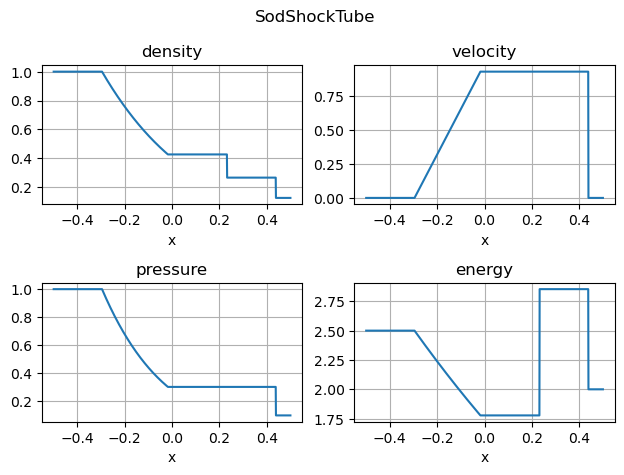

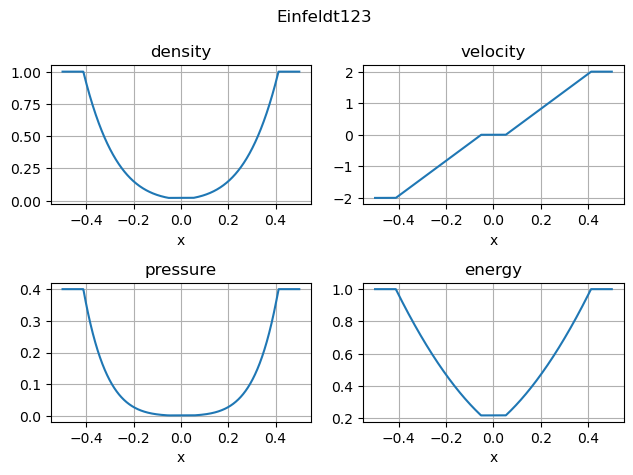

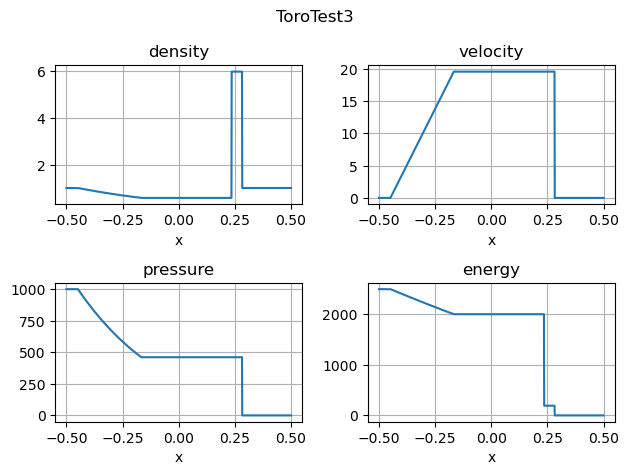

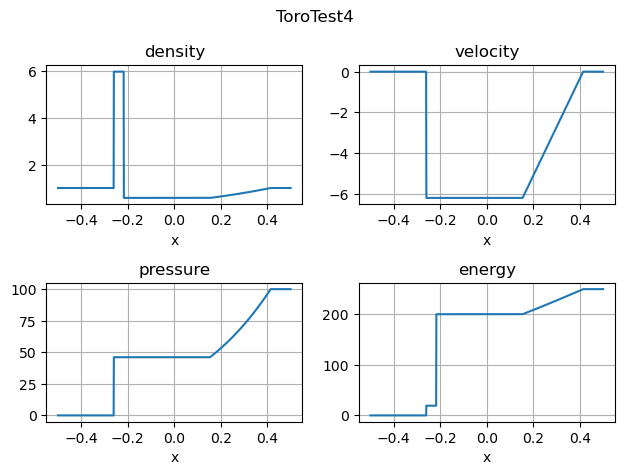

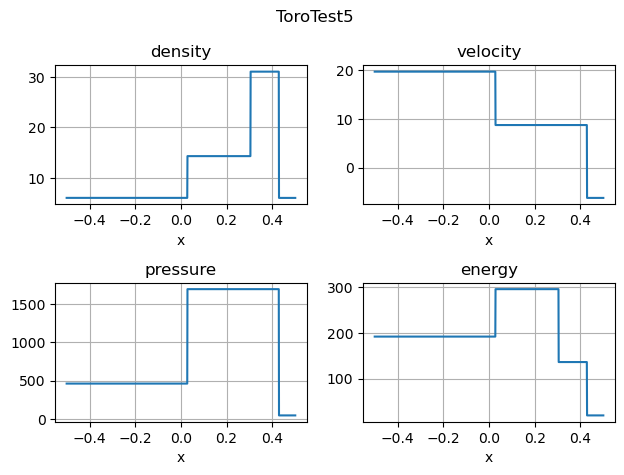

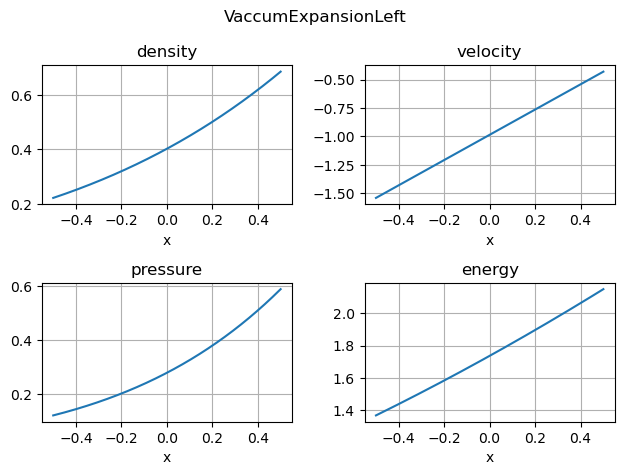

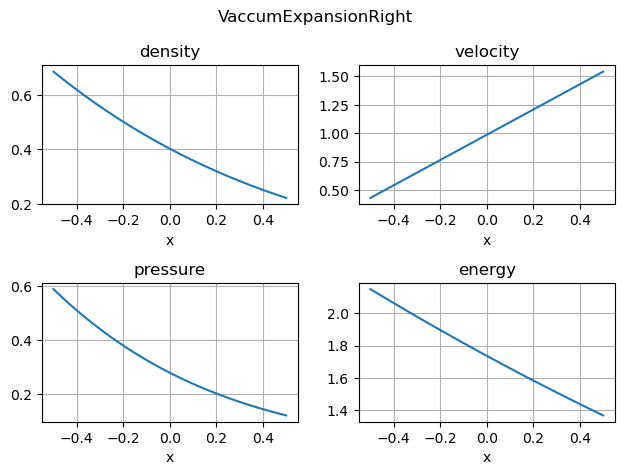

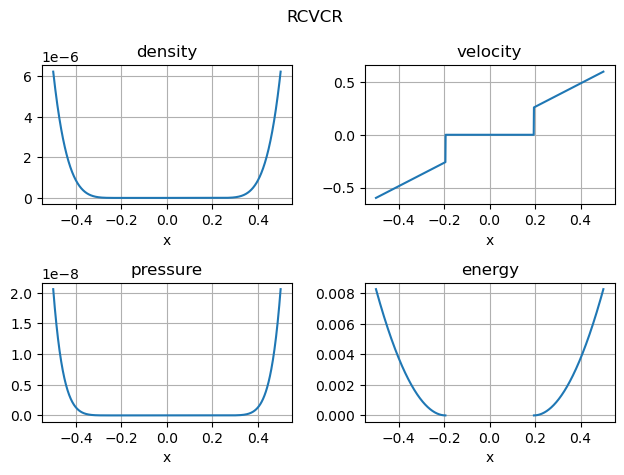

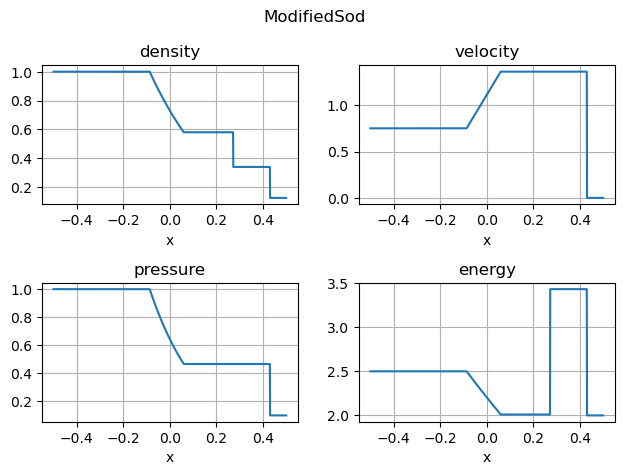

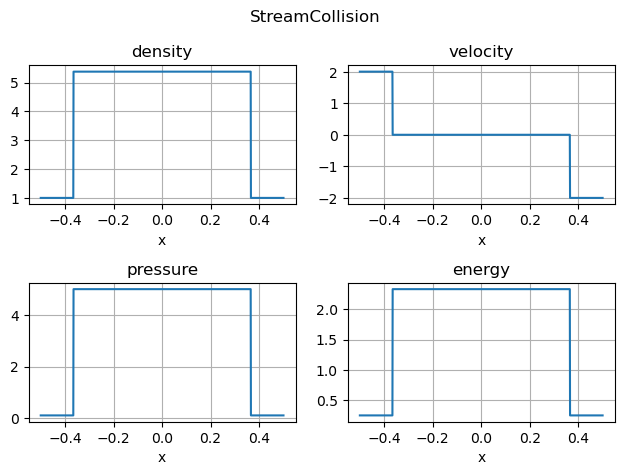

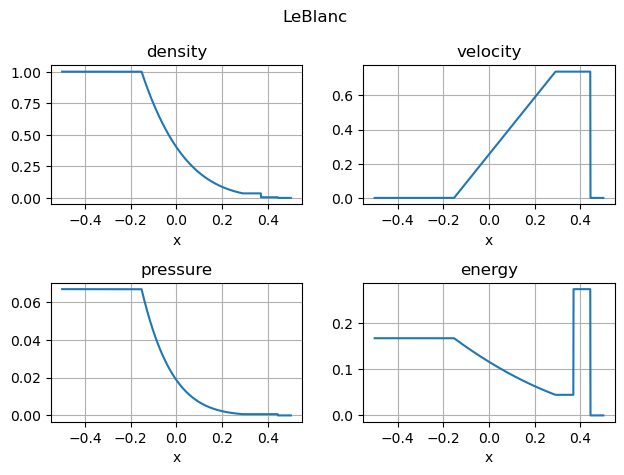

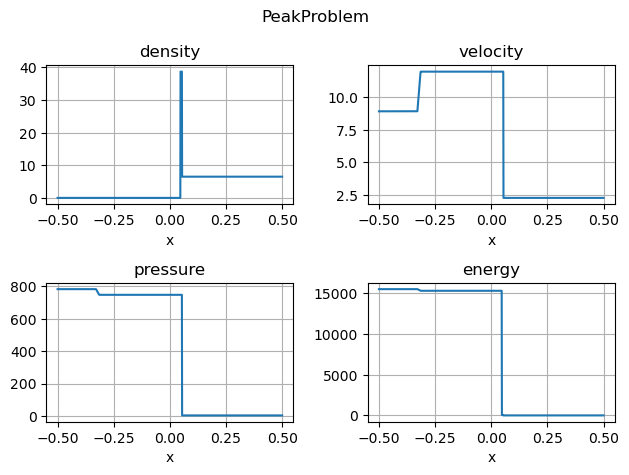

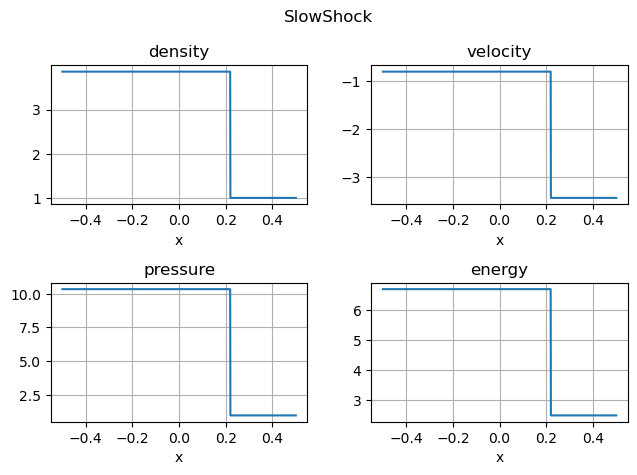

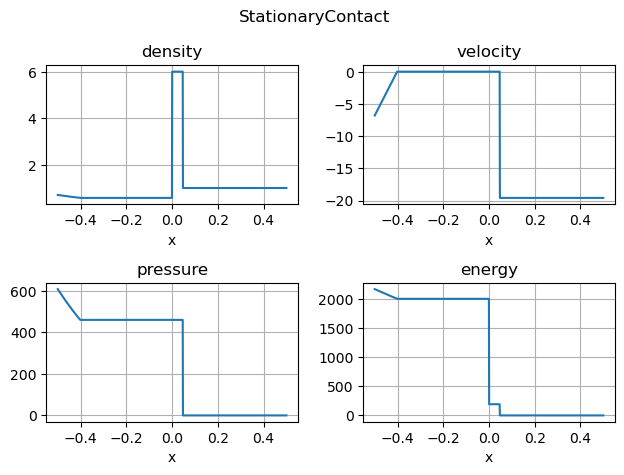

In [2]:
using PyPlot
include("RiemannSolver.jl")

N = 1000
xmin = -0.5
xmax = 0.5
x = collect(LinRange(xmin, xmax, N))
save_figs = true #if this is false the figures will use show(), otherwise they will be saved locally in 'figs' dir

#create directory for figures
if save_figs && !isdir("figs")
	mkdir("figs")
end

struct TestCase
	name::String
	t::Float64
	left::HydroStatus
	right::HydroStatus
end

function calculate_and_plot(test::TestCase)
	name = test.name
	
	println("Time for the test $name:")
	
	#dummy run to compile all code
	sample_riemann(x, test.t, test.left, test.right)
	
	@time profiles = sample_riemann(x, test.t, test.left, test.right)
	density = [status.rho for status in profiles]
	velocity = [status.u for status in profiles]
	pressure = [status.p for status in profiles]
	energy = pressure ./ density ./ (test.left.gamma - 1.)
	
	figure()
	suptitle(name)
	subplot(221)
	plot(x, density)
	title("density")
	xlabel("x")
	grid(true)
	subplot(222)
	plot(x, velocity)
	title("velocity")
	xlabel("x")
	grid(true)
	subplot(223)
	plot(x, pressure)
	title("pressure")
	xlabel("x")
	grid(true)
	subplot(224)
	plot(x, energy)
	title("energy")
	xlabel("x")
	grid(true)
	tight_layout()
	
	if !save_figs
		show()
	else
		
		savefig("figs/$name.pdf",format="pdf",dpi=200)
		savefig("figs/$name.png",format="png",dpi=200)
	end
end

gamma = 7. / 5.

#The first 5 case are taken from Toro's book: (Table 4.1)
#Toro, E.F., Riemann Solvers and Numerical Methods for Fluid Dynamics, A Practical Introduction, 3nd ed., Springer, Berlin, 2009.
#cases 6-13 are takeb from:
#Kamm et. al. 'Enhanced Verification Test Suite for Physics Simulation Codes' SAND2008-7813 2009

#case 1: 
sod = TestCase("SodShockTube",  0.25, HydroStatus(1., 0., 1., gamma),
									  HydroStatus(0.125, 0., 0.1, gamma))
calculate_and_plot(sod)

#case 2: 
einfeldt = TestCase("Einfeldt123",  0.15, HydroStatus(1., -2., 0.4, gamma),
									      HydroStatus(1., 2., 0.4, gamma))
calculate_and_plot(einfeldt)

#case 3:
toro3 =  TestCase("ToroTest3",  0.012, HydroStatus(1., 0., 1000., gamma),
									   HydroStatus(1., 0., 0.1, gamma))
calculate_and_plot(toro3)

#case 4: 
toro4 =  TestCase("ToroTest4",  0.035, HydroStatus(1., 0., 0.01, gamma),
									   HydroStatus(1., 0., 100., gamma))
calculate_and_plot(toro4)

#case 5: 
toro5 =  TestCase("ToroTest5",  0.035, HydroStatus(5.99924, 19.5975, 460.894, gamma),
									   HydroStatus(5.99242, -6.19633, 46.0950, gamma))
calculate_and_plot(toro5)

#case 6: 
vaccum_left =  TestCase("VaccumExpansionLeft",  0.75, HydroStatus(0., 0., 0., gamma),
													  HydroStatus(1., 0., 1., gamma))
calculate_and_plot(vaccum_left)

#case 7: 
vaccum_right =  TestCase("VaccumExpansionRight",  0.75, HydroStatus(1., 0., 1., gamma),
														HydroStatus(0., 0., 0., gamma))
calculate_and_plot(vaccum_right)

#case 8: 
rcvcr =  TestCase("RCVCR",  0.75, HydroStatus(1., -4., 0.4, gamma),
								  HydroStatus(1., 4., 0.4, gamma))
calculate_and_plot(rcvcr)

#case 9:
modified_sod = TestCase("ModifiedSod",  0.2, HydroStatus(1., 0.75, 1., gamma),
											 HydroStatus(0.125, 0., 0.1, gamma))
calculate_and_plot(modified_sod)

#case 9:
stream = TestCase("StreamCollision",  0.8, HydroStatus(1., 2., 0.1, gamma),
										   HydroStatus(1., -2., 0.1, gamma))
calculate_and_plot(stream)

#case 10:
leblanc = TestCase("LeBlanc",  0.5, HydroStatus(1., 0., (2. / 3.)*1.e-1, gamma),
									HydroStatus(1.e-3, 0., (2. / 3.)*1.e-10, gamma))
calculate_and_plot(leblanc)

#case 11:
peak = TestCase("PeakProblem",  3.9e-3, HydroStatus(0.1261192, 8.9047029, 782.92899, gamma),
									    HydroStatus(6.591493, 2.2654207, 3.1544874, gamma))
calculate_and_plot(peak)

#case 12:
slow = TestCase("SlowShock",  2., HydroStatus(3.857143, -0.810631, 10.33333, gamma),
								  HydroStatus(1.0, -3.44, 1.0, gamma))
calculate_and_plot(slow)

#case 13:
stationary = TestCase("StationaryContact",  0.012, HydroStatus(1.0, -19.59745, 1.e3, gamma),
												   HydroStatus(1.0, -19.59745, 1.e-2, gamma))
calculate_and_plot(stationary)

##if you want to profile the tests - remove the following comments
##you will also need a larger N than used before
#
#using Profile
#N = 1000000
#x = collect(LinRange(xmin, xmax, N))
#chosen_test = rcvcr
#sample_riemann(x, test.t, test.left, test.right)
#Profile.clear()
#Profile.clear_malloc_data()
#@time sample_riemann(x, test.t, test.left, test.right)
#@profile sample_riemann(x, test.t, test.left, test.right)
#Profile.print()